In [136]:
# !python3 -m pip install xgboost
# !python3 -m pip install scikit-learn 

In [137]:
import xarray as xr
from xgboost import XGBClassifier
import sklearn
import numpy as np

In [138]:
# RUN_NAME = "LW_CLM_Ex4"
ds = xr.open_dataset(f'east_taylor_data.nc')
end_time = int(max(ds.time))
training_data = ds.sel(time=slice(end_time/2,end_time)).to_dataframe().dropna()
# training_data = training_data.drop()
# testing_data = ds.sel(time=slice(end_time/2,end_time)).to_dataframe()
# data = ds.to_dataframe()
# data = data[data['pressure'] < 0]
# data

In [139]:
# features = [
#     "pressure", "saturation", "volume", "max_volume", "flux_in", "we_predicted", 
#     "permeability_x", "permeability_y", "permeability_z", "porosity", "specific storage", "mannings"
#     ]
features = [
    "pressure", "saturation", "volume", "max_volume", "flux_in", "we_predicted", 
    # "permeability_x", "permeability_y", "permeability_z", 
    "porosity", "specific_storage", 
    "mannings"
    ]
target = ["pressure_becomes_positive"]
x_train, x_validate, y_train, y_validate = sklearn.model_selection.train_test_split(training_data[features], training_data[target], test_size=.2, random_state=1)
# # create model instance
# boost = XGBClassifier(n_estimators=10, max_depth=4, learning_rate=1, objective='binary:logistic')
# # fit model
# boost.fit(x_train, y_train)
# # make predictions
# preds = boost.predict(x_test)

/opt/homebrew/anaconda3/envs/test-env/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:1179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Confusion matrix for our Linear predictor')

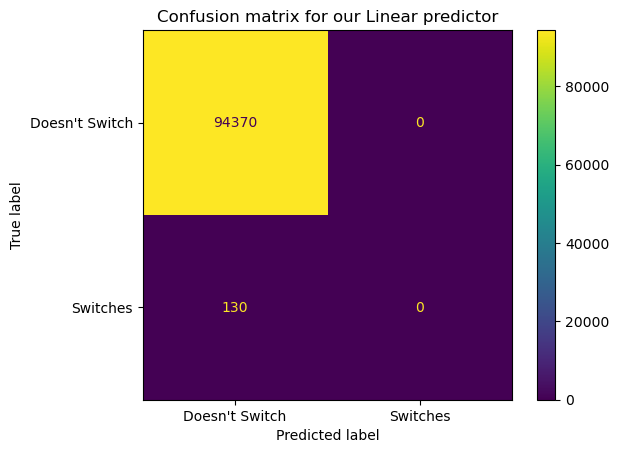

In [140]:
from sklearn.linear_model import RidgeClassifier

linear_model = RidgeClassifier().fit(x_train, y_train)

preds = linear_model.predict(x_validate)

disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_validate[target],
    preds,
    display_labels=["Doesn't Switch", "Switches"]
    )
disp.ax_.set_title("Confusion matrix for our Linear predictor")

In [141]:
params = {
            'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 1.0],
            'subsample': np.arange(0.5, 1.0, 0.1),
            'colsample_bytree': np.arange(0.5, 1.0, 0.1),
            'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
            'n_estimators': [25, 50, 100],
            'max_depth': [2,4,8,16]
        }

xgbclf = XGBClassifier(objective="binary:logistic")
model = sklearn.model_selection.RandomizedSearchCV(estimator=xgbclf,
                            param_distributions=params,
                            scoring='accuracy',
                            n_iter=5,
                            n_jobs=4,
                            verbose=1)

model.fit(x_train, y_train)


best_combination = model.best_params_


Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [142]:
best_model = model.best_estimator_
preds = best_model.predict(x_validate)
print(best_combination)

{'subsample': 0.8999999999999999, 'n_estimators': 25, 'max_depth': 8, 'learning_rate': 0.4, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7999999999999999}


Text(0.5, 1.0, 'Confusion matrix for our XGBoost predictor')

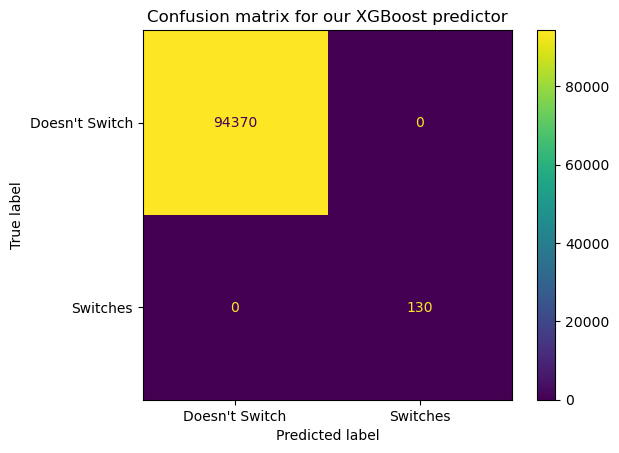

In [143]:
disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
    y_validate[target], 
    preds,
    display_labels=["Doesn't Switch", "Switches"]
    )
disp.ax_.set_title("Confusion matrix for our XGBoost predictor")

In [144]:
# disp = sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
#     y_test[target], x_test["we_predicted"], 
#     display_labels=["Doesn't Switch", "Switches"],

#     )
# disp.ax_.set_title("Confusion matrix for Parflow's current predictor")

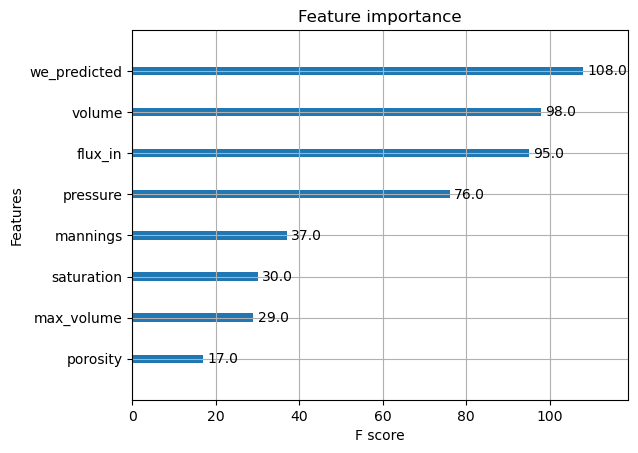

In [145]:
from matplotlib import pyplot

# plot feature importance using built-in function
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(best_model)
pyplot.show()